In [603]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

from pyfinance import TSeries

from hurst import compute_Hc, random_walk


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.decomposition import PCA


from sklearn.cluster import KMeans

In [604]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(15,12)})

In [605]:
import rwi

In [606]:
def load_df(name):
    eurusd_df = pd.read_csv(name)
    eurusd_df = eurusd_df.rename(columns={'<TICKER>':'Ticker', '<DTYYYYMMDD>':'Date', '<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'})
    eurusd_df[['Date']] = pd.to_datetime(eurusd_df['Date'].astype('str'), yearfirst=True)
    eurusd_df =eurusd_df.sort_values(by=['Date', 'Time'])
    eur_df = eurusd_df[['Date', 'Time', 'Close', 'Vol']].rename(columns={'Close':'price'})
    eur_df['returns'] = eur_df['price'].pct_change()
    eur_df.dropna(inplace=True)
    #eur_df = eur_df[eur_df.Date>'2020-01-01']
    #eur_df = eur_df.set_index('Date')
    return eur_df

In [607]:
name='data/fxcm/eurusd_1d.csv'
eur_df = load_df(name)

In [608]:
eur_df = rwi.generate_features(eur_df).fillna(0)

In [609]:
#eur_df = eur_df.set_index('Date')

In [610]:
eur_df['abs_returns'] = eur_df.returns.abs()
eur_df['atr_14'] = eur_df.returns.rolling(14).std().fillna(0)
eur_df['atr_50'] = eur_df.returns.rolling(50).std().fillna(0)
eur_df['atr_200'] = eur_df.returns.rolling(200).std().fillna(0)

In [611]:
eur_df

,Date,Time,price,Vol,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,ROC_200,ROC_500,abs_returns,atr_14,atr_50,atr_200
1,2010-03-02,0,1.36185,44046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2010-03-03,0,1.36993,58804,0.019154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019154,0.000000,0.000000,0.000000
3,2010-03-04,0,1.35806,54033,-0.027648,-0.009024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027648,0.000000,0.000000,0.000000
4,2010-03-05,0,1.36194,37976,0.009322,-0.018584,0.000214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009322,0.000000,0.000000,0.000000
5,2010-03-07,0,1.36359,1891,0.003920,0.013278,-0.014737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003920,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,2020-03-22,0,1.06888,28400,-0.006279,0.051009,-0.260667,-0.394600,-0.298432,-0.335864,-0.349059,-0.414259,-0.573177,0.006279,0.094797,0.061322,0.038523
3091,2020-03-23,0,1.07634,360567,0.104412,0.097477,0.160747,-0.239589,-0.248120,-0.246094,-0.281030,-0.324677,-0.521815,0.104412,0.099372,0.063194,0.039142
3092,2020-03-24,0,1.07977,288802,0.043249,0.152176,0.144942,-0.148158,-0.232235,-0.212830,-0.241837,-0.290445,-0.478352,0.043249,0.097454,0.063538,0.039266
3093,2020-03-25,0,1.08881,266724,0.108632,0.156579,0.277340,0.342496,-0.214342,-0.123156,-0.123320,-0.215122,-0.415090,0.108632,0.104112,0.065454,0.040022


In [453]:
### 1. PCA, k-means clustering

In [612]:
eur_df.columns

Index(['Date', 'Time', 'price', 'Vol', 'returns', 'ROC_2', 'ROC_3', 'ROC_5',
       'ROC_20', 'ROC_50', 'ROC_100', 'ROC_200', 'ROC_500', 'abs_returns',
       'atr_14', 'atr_50', 'atr_200'],
      dtype='object')

In [645]:
X = eur_df.copy().drop(columns=['Time', 'price' ,'Vol', 'returns', 'abs_returns', 'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'atr_14'])

In [646]:
X = X.set_index('Date')

In [647]:
pca = PCA(n_components=3)

pca_X = pca.fit_transform(X.fillna(0)) 

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.59757539 0.26011942 0.10337607]
[34.79403671 22.95592809 14.47166439]


In [648]:
pca_X = pd.DataFrame(pca_X, columns=['p1', 'p2', 'p3'])

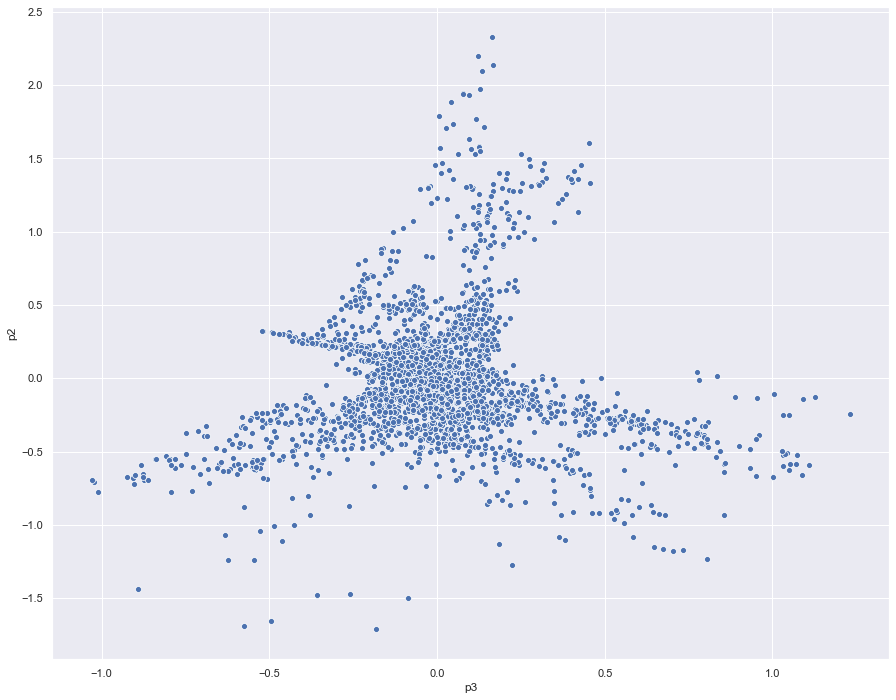

In [649]:
#1
ax = sns.scatterplot(x='p3', y='p2', data=pca_X)


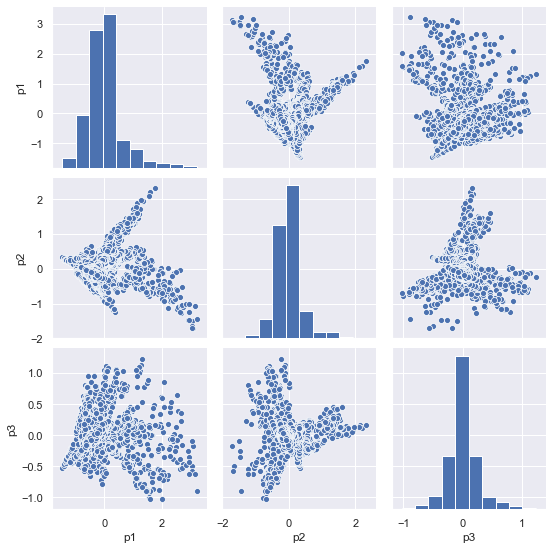

In [650]:

ax = sns.pairplot( data=pca_X)


In [662]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_X)
kmeans.labels_

y = kmeans.predict(pca_X)

kmeans.cluster_centers_

array([[ 0.59013219,  0.75191323,  0.06979137],
       [ 1.61988644, -0.43322172, -0.24164693],
       [-0.20544843, -0.06885067,  0.00917131]])

In [663]:
X = X.reset_index()
X['cluster'] = y
X['price'] = eur_df.price

In [664]:
eur_df.price

1       1.36185
2       1.36993
3       1.35806
4       1.36194
5       1.36359
         ...   
3090    1.06888
3091    1.07634
3092    1.07977
3093    1.08881
3094    1.10469
Name: price, Length: 3094, dtype: float64

In [665]:
eur_df

,Date,Time,price,Vol,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,ROC_200,ROC_500,abs_returns,atr_14,atr_50,atr_200
1,2010-03-02,0,1.36185,44046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2010-03-03,0,1.36993,58804,0.019154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019154,0.000000,0.000000,0.000000
3,2010-03-04,0,1.35806,54033,-0.027648,-0.009024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027648,0.000000,0.000000,0.000000
4,2010-03-05,0,1.36194,37976,0.009322,-0.018584,0.000214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009322,0.000000,0.000000,0.000000
5,2010-03-07,0,1.36359,1891,0.003920,0.013278,-0.014737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003920,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,2020-03-22,0,1.06888,28400,-0.006279,0.051009,-0.260667,-0.394600,-0.298432,-0.335864,-0.349059,-0.414259,-0.573177,0.006279,0.094797,0.061322,0.038523
3091,2020-03-23,0,1.07634,360567,0.104412,0.097477,0.160747,-0.239589,-0.248120,-0.246094,-0.281030,-0.324677,-0.521815,0.104412,0.099372,0.063194,0.039142
3092,2020-03-24,0,1.07977,288802,0.043249,0.152176,0.144942,-0.148158,-0.232235,-0.212830,-0.241837,-0.290445,-0.478352,0.043249,0.097454,0.063538,0.039266
3093,2020-03-25,0,1.08881,266724,0.108632,0.156579,0.277340,0.342496,-0.214342,-0.123156,-0.123320,-0.215122,-0.415090,0.108632,0.104112,0.065454,0.040022


In [666]:
X.index.max()

3093

In [667]:
X

,index,Date,ROC_50,ROC_100,ROC_200,ROC_500,atr_50,atr_200,cluster,price
0,0,2010-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,NaN
1,1,2010-03-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1.36185
2,2,2010-03-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1.36993
3,3,2010-03-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1.35806
4,4,2010-03-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1.36194
...,...,...,...,...,...,...,...,...,...,...
3089,3089,2020-03-22,-0.335864,-0.349059,-0.414259,-0.573177,0.061322,0.038523,2,1.06933
3090,3090,2020-03-23,-0.246094,-0.281030,-0.324677,-0.521815,0.063194,0.039142,2,1.06888
3091,3091,2020-03-24,-0.212830,-0.241837,-0.290445,-0.478352,0.063538,0.039266,2,1.07634
3092,3092,2020-03-25,-0.123156,-0.123320,-0.215122,-0.415090,0.065454,0.040022,2,1.07977


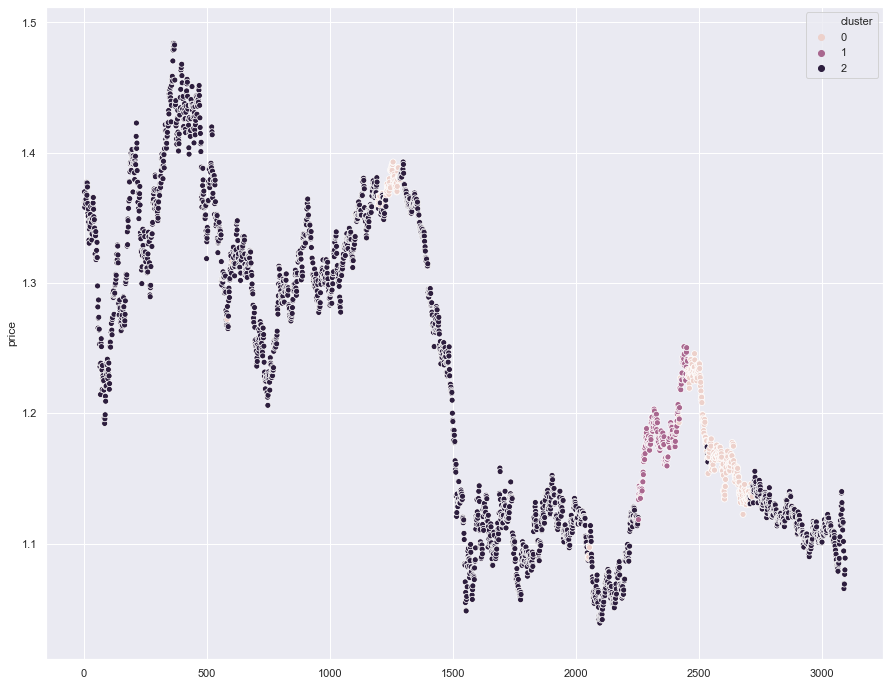

In [668]:
sns.scatterplot(x=X.reset_index().index, y=X['price'], hue='cluster', data=X[['price', 'cluster']])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D594930F88>,
      dtype=object)

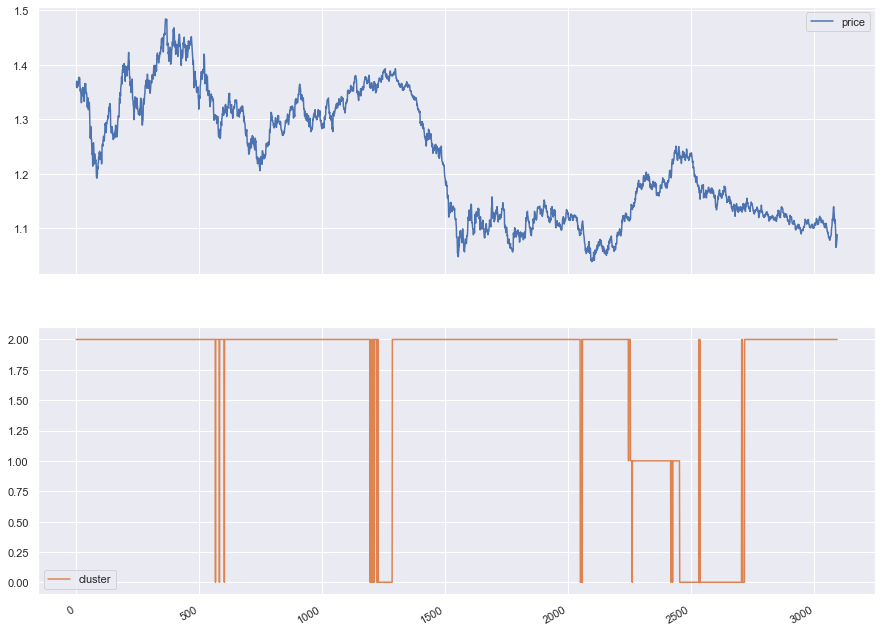

In [669]:
X[['price', 'cluster']].plot(subplots=(2,1))

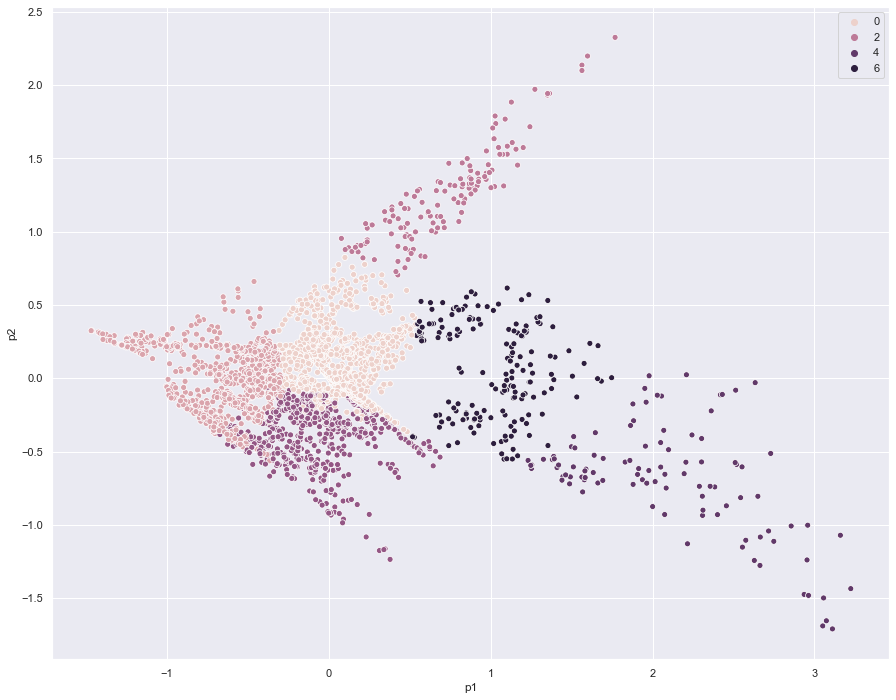

In [659]:
ax = sns.scatterplot(x='p1', y='p2', hue=y, data=pca_X)

In [123]:
X

,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,ROC_200,ROC_500,abs_returns,atr_14,cluster,price
Date,,,,,,,,,,,,,
2010-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1.36185
2010-03-03,0.019154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019154,0.000000,1,1.36993
2010-03-04,-0.027648,-0.009024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027648,0.000000,1,1.35806
2010-03-05,0.009322,-0.018584,0.000214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009322,0.000000,1,1.36194
2010-03-07,0.003920,0.013278,-0.014737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003920,0.000000,1,1.36359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,-0.006279,0.051009,-0.260667,-0.394600,-0.298432,-0.335864,-0.349059,-0.414259,-0.573177,0.006279,0.094797,5,1.06888
2020-03-23,0.104412,0.097477,0.160747,-0.239589,-0.248120,-0.246094,-0.281030,-0.324677,-0.521815,0.104412,0.099372,5,1.07634
2020-03-24,0.043249,0.152176,0.144942,-0.148158,-0.232235,-0.212830,-0.241837,-0.290445,-0.478352,0.043249,0.097454,5,1.07977


In [473]:
# optimal set of indicators, critical adding wrong indicator messes up everythng
# PCA, HMM, GMM or auto-encoders are effective?
# what are paramters
# what is number of clusters?
# we have clusters regimes. Which one will help to outperform market?
# how to deal with multiple regimes?
# how to know that success wasnt due to random chance?


In [474]:
# what is definition of good cluster?
# good good result looks like?
# how it can be measured?

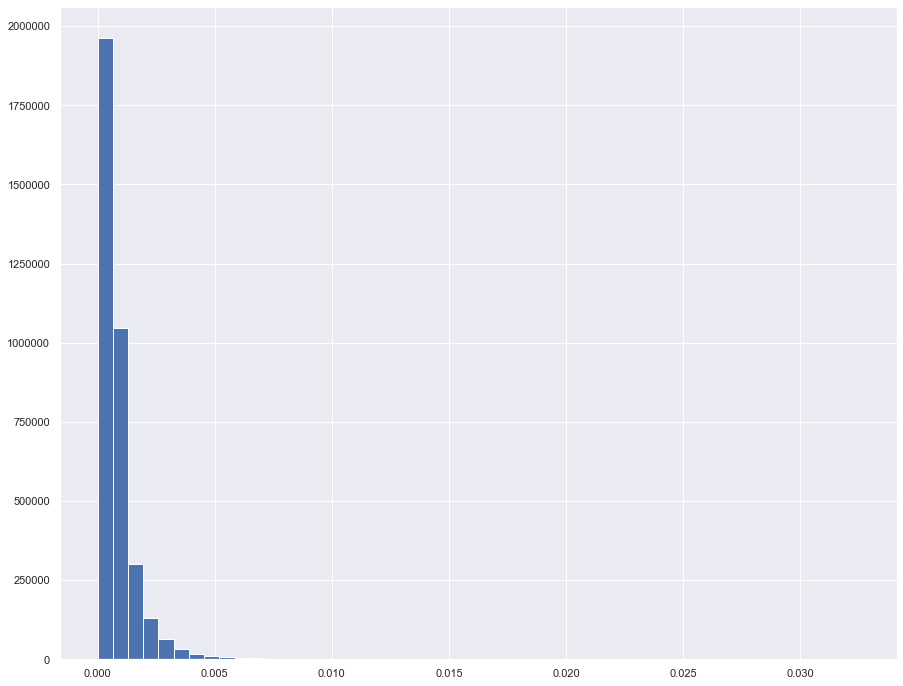

In [478]:
X.atr_50.hist(bins=50)

In [568]:
thresh = eur_df.atr_50.mean() 

In [569]:
eur_df['regime'] = eur_df['atr_50'].apply(lambda x: 1 if x > thresh else 0)

In [578]:
eur_df['shift_returns'] = eur_df.returns.shift(-1).fillna(0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D583D0FF08>,
      dtype=object)

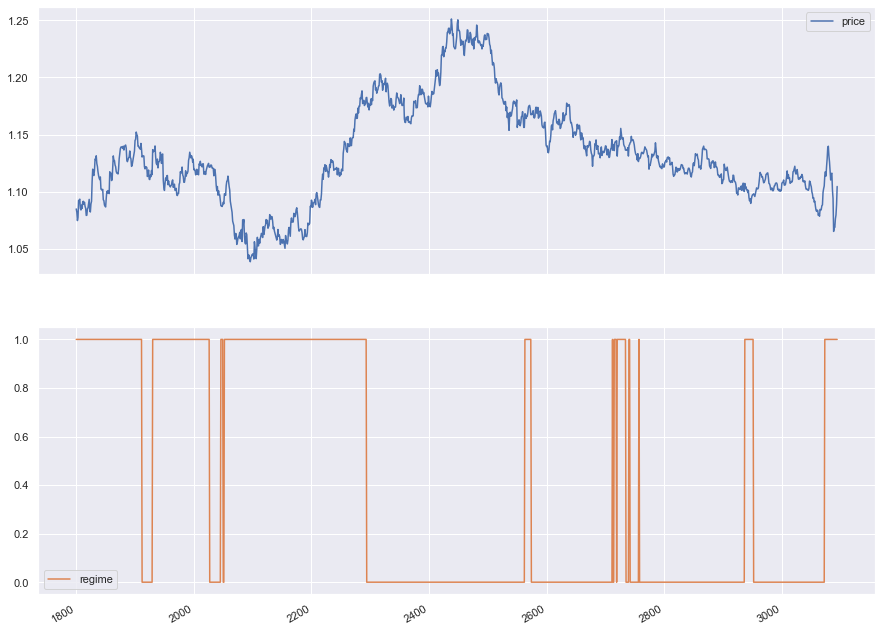

In [570]:
eur_df[eur_df.Date > '2016-01-01'][['price', 'regime']].plot(subplots=(2,1))

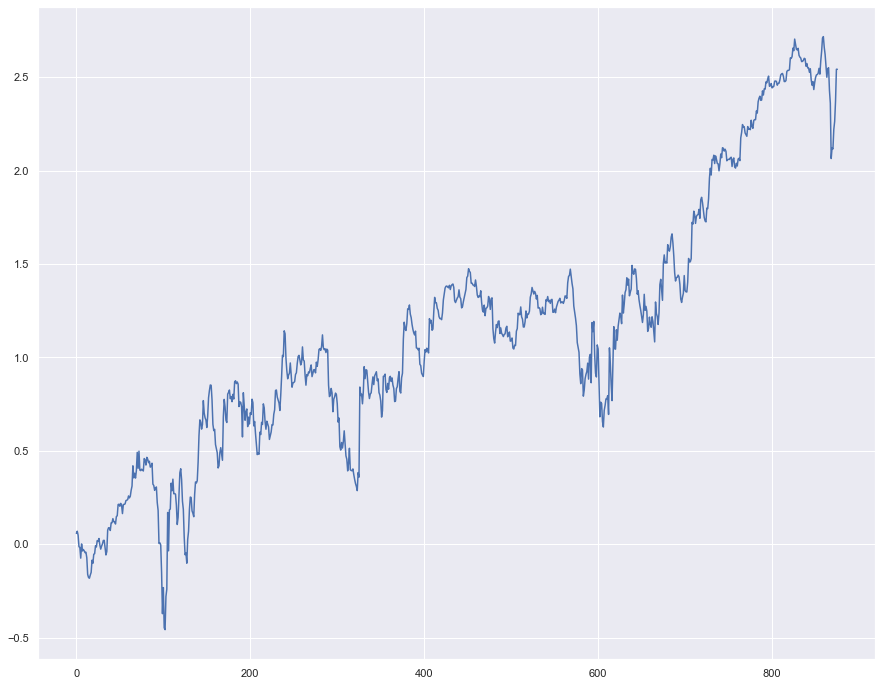

In [579]:
eur_df[eur_df.regime==1].reset_index().shift_returns.cumsum().plot()

In [599]:
eur_df[eur_df.regime==1].shift_returns.mean() * 100

0.29020674523226253

In [600]:
eur_df[eur_df.regime==1].shape

(876, 19)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


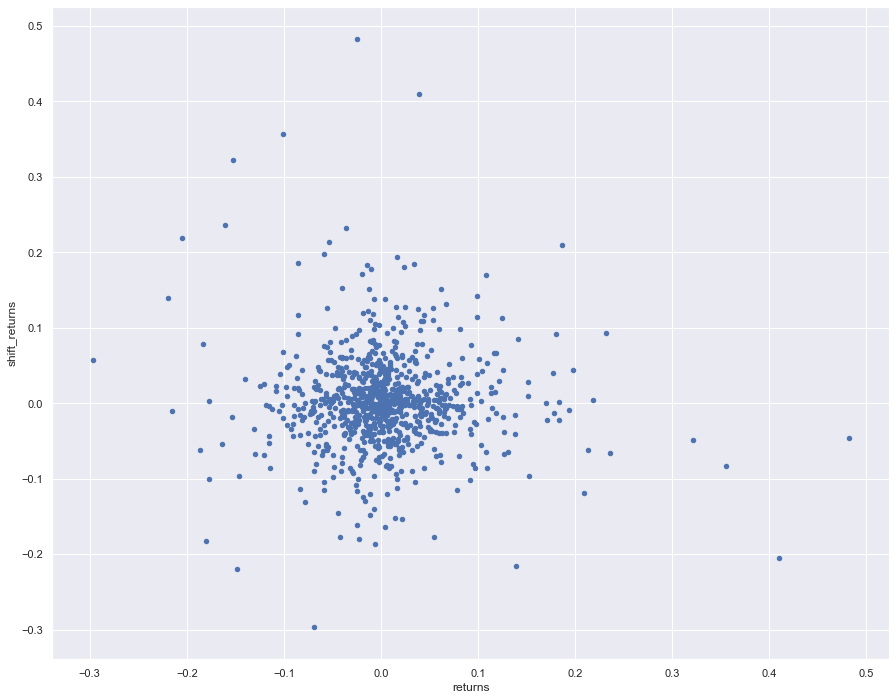

In [595]:
eur_df[eur_df.regime==1][['atr_14', 'returns', 'shift_returns']].plot.scatter(x='returns', y='shift_returns')

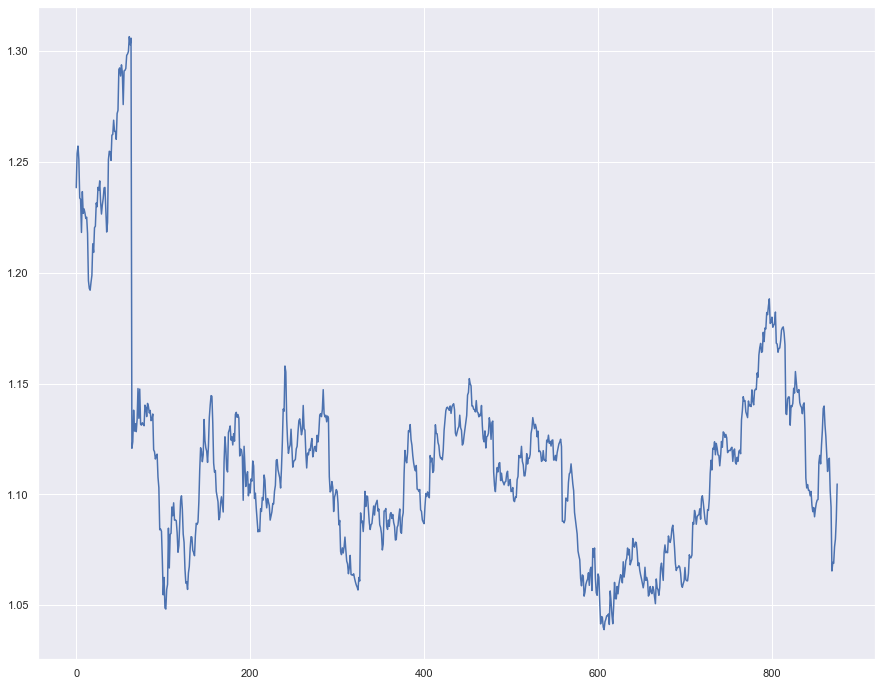

In [582]:
eur_df[eur_df.regime==1].reset_index().price.plot()

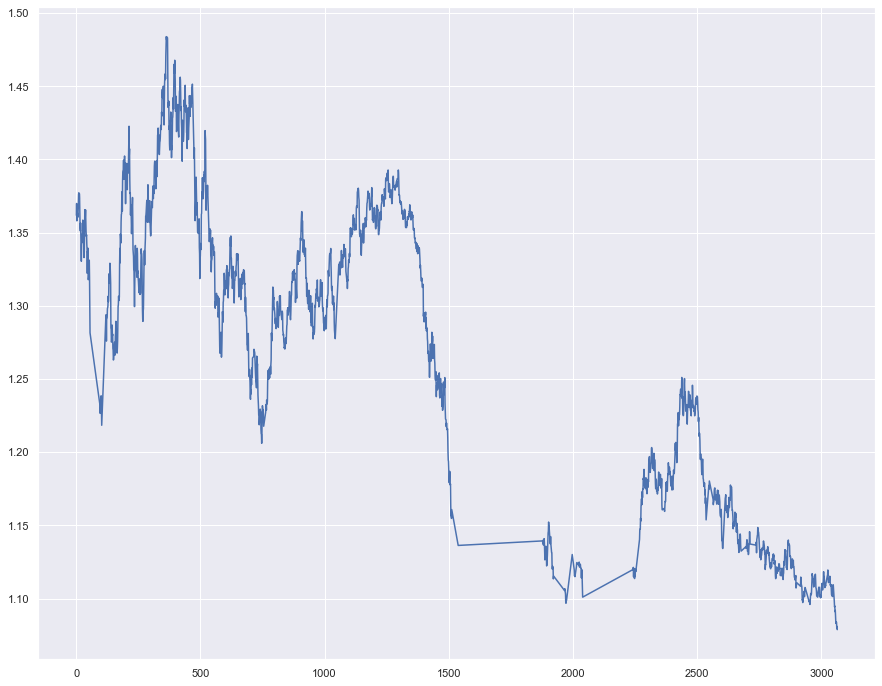

In [564]:
eur_df[eur_df.regime==0].price.plot()

In [602]:

### finalize my strategies vectorized backtesting with performance results
# methods to analyze returns due to selection, clsutering
### pca overfit

### ML with shift roc by period amount
### implement backtesting of ML models including MA models